# 2D plotting of LES output vs. satellite imagery (work in progress)
## Updated as of 6/24/25
* The below notebook compares selected simulations against observational targets that were collected from satellite and ground-based retrievals.
* Figure 6 is generated from this notebook
* In case of questions or concerns, please notify Ann Fridlind (ann.fridlind@nasa.gov), Timothy Juliano (tjuliano@ucar.edu), and Florian Tornow (ft2544@columbia.edu).

In [1]:

import glob, os
import geopy
import geopy.distance
 
os.getcwd()


'/user-data-home/comble-mip/notebooks/plotting/paper'

In [2]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")

%run functions_plotting.py 
%run function_plotting_2d.py 

## read trajectory
ds = nc.Dataset('../../data_files/theta_temp_rh_sh_uvw_sst_along_trajectory_era5ml_28h_end_2020-03-13-18.nc')
les_time = 18. + ds['Time'][:]
    
## select simulations to plot
sim_keyword = 'FixN_2D'  

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


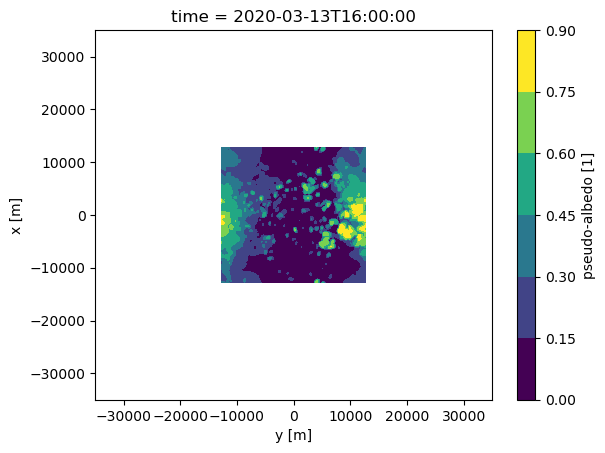

In [3]:
test_dharma = xr.open_dataset('/data/project/comble-mip/output_les/dharma/DHARMA_Lx25_dx100_FixN_2D.nc')
test_dharma['alb'].sel(time='2020-03-13T16:00:00.00').plot.contourf(xlim=(-35000,35000),ylim=(-35000,35000))

In [4]:
## select times
#Time_Vec = [0.,1.,2.,6.,10.,14.,18.] ## hours, where 18 h marks arrival
Time_Vec = [4.,16.] ## hours, where 18 h marks arrival

## select acceptable window of time
Time_Window = 15.0  ## hours

## set domain to be extracted
Spat_Window = 100.0 ## km

## downscale to 1 km resolution (default: True)
upscale = True

## repeat small domain output to match large domain (default: False)
tiling = False 

In [5]:
## convert to regular time
tprop = []
for toi in Time_Vec:
    tprop.append(np.datetime64('2020-03-13T00:00:00') + np.timedelta64(int(toi),'h'))
           

In [6]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")
%run functions_plotting.py 

var_vec_2d = ['alb','opt']

## load all simulations located in subfolders of the given directory
if upscale:
    df_col_2d = load_sims_2d('/data/project/comble-mip/output_les/',var_vec_2d,t_shift=-2,keyword=sim_keyword,times=[t for t in Time_Vec if t > 0],coarsen=False)
    df_col_2d['x'] = np.round(df_col_2d['x']/1000,1)
    df_col_2d['y'] = np.round(df_col_2d['y']/1000,1)
    df_col_2d = df_col_2d.rename({'y':'y_round','x':'x_round'})
else:
    df_col_2d = load_sims_2d('/data/project/comble-mip/output_les/',var_vec_2d,t_shift=-2,keyword=sim_keyword,times=[t for t in Time_Vec if t > 0],coarsen=True)

Loading variables: f(time,x,y)
/data/project/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN_2D.nc
NaN values in alb
NaN values in opt
/data/project/comble-mip/output_les/dharma/DHARMA_Lx125_dx100_FixN_2D.nc
/data/project/comble-mip/output_les/dharma/DHARMA_Lx25_dx100_FixN_2D.nc
/data/project/comble-mip/output_les/uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
...adjusting x and y values


In [7]:
## load satellite imagery

os.chdir("/data/project/comble-mip/satellite_imagery/viirs/")
counter_dat = 0
for file in glob.glob("*03DNB*.nc"):
    
    ## load geolocation    
    ds_geo = nc.Dataset("/data/project/comble-mip/satellite_imagery/viirs/" + file)
    
    ## load imagery
    file_sp = file.split('.')    
    file_img = glob.glob(file_sp[0].replace('3','2')+'.'+file_sp[1]+'.'+file_sp[2]+'*')[0]
    ds_img = nc.Dataset("/data/project/comble-mip/satellite_imagery/viirs/" + file_img)
    
    ## time
    file_time = np.datetime64('2020-01-01') + np.timedelta64(int(file_sp[1][5:8])-1,'D') + np.timedelta64(int(file_sp[2][0:2]),'h')+ np.timedelta64(int(file_sp[2][2:4]),'m')
    
    print(file)
    print(file_img)    
    
    ## for each requested model timestep, check if image covers right place at right time
    counter_time = 0
    for Time_OI in tprop:
        diff_time = (file_time - np.datetime64(Time_OI))/np.timedelta64(1, 's')/3600
        if np.abs(diff_time) <= Time_Window:
            print(Time_OI)
            Traj_time = (Time_OI - np.datetime64('2020-03-13T18:00:00'))/np.timedelta64(1, 's')/3600
            Lat_OI = ds['Latitude'][ds['Time'][:]==Traj_time][0]
            Lon_OI = ds['Longitude'][ds['Time'][:]==Traj_time][0]
            
            ## create spatial window around coordinate of interest
            start = geopy.Point(Lat_OI, Lon_OI)
            d = geopy.distance.distance(kilometers=1.2*Spat_Window/2)
            
            LAT_MIN = d.destination(point=start, bearing=180)[0]
            LAT_MAX = d.destination(point=start, bearing=0)[0]
            LON_MIN = d.destination(point=start, bearing=270)[1]
            LON_MAX = d.destination(point=start, bearing=90)[1]
            
            ## select pixels within window
            pix_num = ((ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                       (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                       (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                       (ds_geo['geolocation_data/longitude'][:] < LON_MAX)).sum()
            print(pix_num)
            
            if pix_num > 0:
                
                ds_sub = ds_img['observation_data/DNB_observations'][:,:][(ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                                                                          (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                                                                          (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                                                                          (ds_geo['geolocation_data/longitude'][:] < LON_MAX)]
                ds_lat = ds_geo['geolocation_data/latitude'][:,:][(ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                                                                  (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                                                                  (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                                                                  (ds_geo['geolocation_data/longitude'][:] < LON_MAX)]
                ds_lon = ds_geo['geolocation_data/longitude'][:,:][(ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                                                                   (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                                                                   (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                                                                   (ds_geo['geolocation_data/longitude'][:] < LON_MAX)]
                da = xr.DataArray(
                    name = 'alb',
                    data = ds_sub,
                    dims = ['pixel'],
                    coords = dict(
                        lon = (['pixel'],ds_lon),
                        lat = (['pixel'],ds_lat)
                    ))
            
                ## compute meridional and latitudal distance to center
                da['x_dist'] = 0*da['lat']
                da['y_dist'] = 0*da['lat']
                for ii in range(len(ds_sub)):
                    da['x_dist'][ii] = geopy.distance.geodesic((da['lat'][ii],da['lon'][ii]), 
                                                               (da['lat'][ii],Lon_OI)).km * np.sign((da['lon'][ii].data - Lon_OI))
                    da['y_dist'][ii] = geopy.distance.geodesic((da['lat'][ii],da['lon'][ii]), 
                                                               (Lat_OI,da['lon'][ii])).km * np.sign((da['lat'][ii].data - Lat_OI)) 
                
                ## limit to requested size
                da = da[np.abs(da['x_dist']) <= Spat_Window/2]
                da = da[np.abs(da['y_dist']) <= Spat_Window/2]
                
                ## normalize radiance values to resemble LES pseudo-albedo
                ## (using quantiles to avoid dominance of few bright pixels)
                fact = 0.9
                if Time_OI in df_col_2d['time']:
                    fact = df_col_2d['alb'].sel(time=Time_OI).quantile(q=0.8).data
                da.data = ((da.data - da.data.min())/(da.quantile(q=0.8).data - da.data.min()))*fact
                    
                da['x_round'] = np.round(da['x_dist'])
                da['y_round'] = np.round(da['y_dist'])
                
                for yy in np.unique(da['y_round']):
                    da_sub = da[da['y_round'] == yy]
                    da_stat = da_sub.groupby('x_round').mean() 
                    da_stat['y_round'] = np.float64(yy)
                    if yy == np.unique(da['y_round'])[0]:
                        da_stat_stack = xr.concat([da_stat],dim='y_round')
                    else:
                        da_stat_stack = xr.concat([da_stat_stack,da_stat],dim='y_round')
                
                if upscale:
                    x_round_new = np.round(np.linspace(da_stat_stack.x_round[0], da_stat_stack.x_round[-1], 10*len(da_stat_stack['x_round'])-9),1) # da_stat_stack["x_round"] * 4)
                    y_round_new = np.round(np.linspace(da_stat_stack.y_round[0], da_stat_stack.y_round[-1], 10*len(da_stat_stack['y_round'])-9),1) # da_stat_stack["x_round"] * 4)
                    da_stat_stack = da_stat_stack.interp(x_round=x_round_new,y_round=y_round_new)
                
                da_stat_stack['time'] = Time_OI
                da_stat_stack['time_diff'] = diff_time
                if counter_time == 0:
                    da_stat_stst = xr.concat([da_stat_stack],dim='time')
                else:
                    da_stat_stst = xr.concat([da_stat_stst,da_stat_stack],dim='time')
                counter_time += 1
                
    da_stat_stst['Source'] = file_sp[0]+'.'+file_sp[1]+'.'+file_sp[2]
    if counter_dat == 0:
        da_stat_ststst = xr.concat([da_stat_stst],dim='Source')
    else:
        da_stat_ststst = xr.concat([da_stat_ststst,da_stat_stst],dim='Source')
    counter_dat += 1

VNP03DNB.A2020073.1306.002.2021125004801.nc
VNP02DNB.A2020073.1306.002.2021126174604.nc
2020-03-13T04:00:00
25770
2020-03-13T16:00:00
0
VJ103DNB.A2020073.1212.002.2020073175644.nc
VJ102DNB.A2020073.1212.002.2020073182754.nc
2020-03-13T04:00:00
26125
2020-03-13T16:00:00
26373


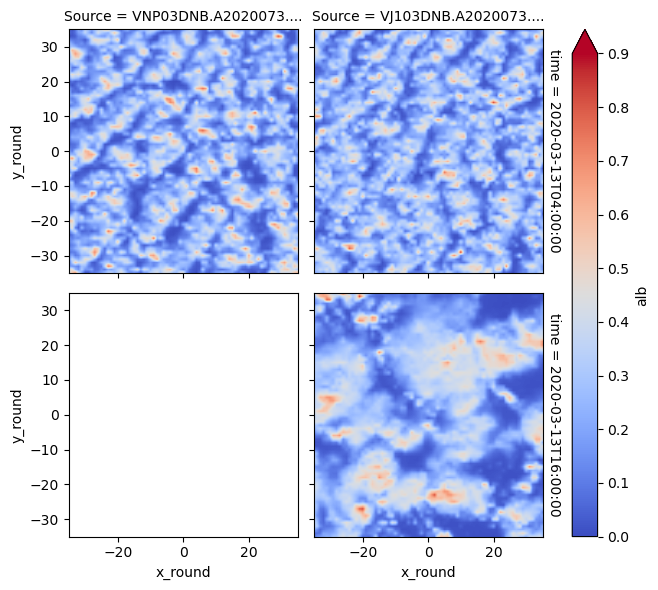

In [8]:
da_stat_ststst.plot(row='time',col='Source',xlim=(-35,35),ylim=(-35,35),vmin=0.0,vmax=0.9,cmap='coolwarm')

<xarray.DataArray 'alb' (Source: 1, time: 2, x_round: 1001, y_round: 1001)> Size: 16MB
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[0.54709029, 0.54676737, 0.54644445, ...,        nan,
                 nan,        nan],
         [0.54282414, 0.54214424, 0.54146434, ...,        nan,
                 nan,        nan],
         [0.53855799, 0.53752111, 0.53648422, ...,        nan,
                 nan,        nan],
         ...,
         [0.2945543 , 0.29416429, 0.29377427, ...,        nan,
                 nan,        nan],
         [0.29590635, 0.29518852, 0.29447069, ...,        nan,
                 nan,        nan],
         [0.29725841, 0.29621276, 0.29516711, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * y_round    (y_round) float64 8kB -50.0 -49.9 -49.8 -49.7 ... 49.8 49.9 50.0
  * x_round    (x_round) float64 8kB -50.0 -49.9 -49.8 -49.7 ... 49.8 49.9 50.0
  * time       (time) datetime64[ns] 16B 2020-03-13T04:00:00 2020-03-13T16:00:00
  * Source     (Source) <U22 88B 'VJ103DNB.A2020073.1212'
    time_diff  (Source, time) float64 16B 8.2 -3.8

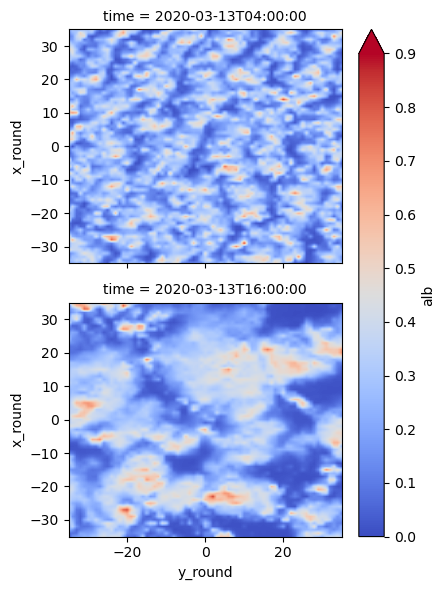

In [11]:
da_stat_ststst_slice = da_stat_ststst.copy(deep=True)
da_stat_ststst_slice = da_stat_ststst_slice.where(da_stat_ststst_slice.Source!=da_stat_ststst_slice.Source[0], drop=True)
da_stat_ststst_slice = da_stat_ststst_slice.rename({'x_round':'y_round','y_round':'x_round'})
#da_stat_ststst_slice = da_stat_ststst_slice.transpose('Source', 'time', 'x_round', 'y_round')
#da_stat_ststst_slice = da_stat_ststst_slice.swap_dims({'y_round': 'x_round'}) 
#da_stat_ststst_slice = da_stat_ststst_slice.roll(y_round=-1, roll_coords=False).transpose()
#da_stat_ststst_slice = da_stat_ststst_slice[["Source", "time", "x_round", "y_round", "alb"]]
da_stat_ststst_slice[0,:,:,:].plot(aspect=1.1,row='time',xlim=(-35,35),ylim=(-35,35),vmin=0.0,vmax=0.9,cmap='coolwarm')
da_stat_ststst_slice

In [12]:
#plt.rcParams['font.size'] = 14 # Set global font size
plt.rcParams['axes.titlesize'] = 14 # Set title font size
plt.rcParams['axes.labelsize'] = 14 # Set axis label font size
plt.rcParams['xtick.labelsize'] = 14 # Set x-tick label font size
plt.rcParams['ytick.labelsize'] = 14 # Set y-tick label font size

## Drop WRF, we don't have the pseudo-albedo outputs

In [26]:
import copy
df_col_2d_slice = copy.deepcopy(df_col_2d)
df_col_2d_slice = df_col_2d_slice.drop_sel(Source='wrf/WRF_Lx25_dx100_FixN_2D.nc')

## Create Fig. 6

In [28]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/paper/")
#ds_merge.plot(row='time',col='Source',vmin=16,vmax=24,xlim=(-35,35),ylim=(-35,35),cmap='coolwarm')
cf1 = xr.merge([df_col_2d_slice['alb'],da_stat_ststst_slice.drop('time_diff')])['alb'].plot(aspect=1.1,row='time',col='Source',xlim=(-35,35),ylim=(-35,35),vmin=0.0,vmax=0.9,cmap='coolwarm')
titles = ['VIIRS','DHARMA Production Domain','DHARMA Toy Domain','UCLALES-SALSA Toy Domain']
for ax, title in zip(cf1.axes.flat, titles):
    ax.set_title(title)
    #ax.set_xlabel('Distance [km]')
for i in np.arange(len(Time_Vec)):
    cf1.axs[i,0].set_ylabel('Distance [km]')
for i in np.arange(4):
    cf1.axs[-1,i].set_xlabel('Distance [km]')
cf1.cbar.set_label(label='Pseudo-Albedo [-]', size=14)
#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
for ax in cf1.axs.flat:
    ax.invert_xaxis()
    ax.invert_yaxis()

#for i in np.arange(len(Time_Vec)):
#    for j in np.arange(4):
#        cf1.axs[i,j+1].invert_xaxis()
#        cf1.axs[i,j+1].invert_yaxis()

#print (cf1.title[0,0])
    
#cf1.axs[0,0].invert_xaxis()
#cf1.axs[0,0].invert_yaxis()
plt.savefig('viirs_les_panel.png',dpi=600,bbox_inches='tight')
plt.close()
#plt.show()

/tmp/ipykernel_1783/3918853439.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  cf1 = xr.merge([df_col_2d_slice['alb'],da_stat_ststst_slice.drop('time_diff')])['alb'].plot(aspect=1.1,row='time',col='Source',xlim=(-35,35),ylim=(-35,35),vmin=0.0,vmax=0.9,cmap='coolwarm')
/tmp/ipykernel_1783/3918853439.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, title in zip(cf1.axes.flat, titles):
